In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

from multiprocessing import Pool

%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [25]:
def model(theta,nu=nu):
    nwh,a1,a2,a3,b1,b2,b3, nu_max1,sig_nu1,amp1, nu_max2,sig_nu2,amp2= theta
    #not sure what to do about attenuation term here
    att = atten()
    gau1 = att*amp1*np.exp(-(nu-nu_max1)**2/(2*sig_nu1**2))
    gau2 = att*amp2*np.exp(-(nu-nu_max2)**2/(2*sig_nu2**2))
    model = nwh + att* (a1/(1+(nu/b1)**4) + a2/(1+(nu/b2)**4) + a3/(1+(nu/b3)**4))
    model = model + gau1 + gau2
    return model

def atten(nu=nu):
    atten  = (np.sinc((nu)/(2*283.212)))**2
    return atten

def lnlike(theta, x, y, yerr):
    #this should be fine but dependent on what we chose yerr to be
    Lnlike = -1/2 * np.sum(((y - model(theta, nu))/yerr)**2)
    return Lnlike

def lnprior(theta):
    nwh, a1, a2, a3, b1, b2, b3, nu_max1,sig_nu1,amp1, nu_max2,sig_nu2,amp2= theta
    #this is gross surely there is a way to make this look nicer
    if (130 < nwh < 160) and (100000 < a1 < 110000) and (22000 < a2 < 23000) and (2000 < a3 < 5000) and (1 < b1 < 5) and (5 < b2 < 8) and (10 < b3 < 30)and (6 < nu_max1 < 8) and (0.5< sig_nu1 < 1.5) and (40000< amp1 < 60000) and (15.5 < nu_max2 < 17.5) and (3< sig_nu2 < 5) and (5000< amp2 <15000):
        return 0.0
    else:
        return -np.inf
    
    
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if (lp == -np.inf):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr) 


def main(p0,nwalkers,niter,ndim,lnprob,data):
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data, pool=pool)

        print("Running burn-in...")
        p0, _, _ = sampler.run_mcmc(p0, 100, progress=True)
        sampler.reset()

        print("Running production...")
        pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

        return sampler, pos, prob, state


In [2]:
import lightkurve as lk
search = lk.search_lightcurvefile('2568888',mission='Kepler')
print(search)
files = search.download_all()
lc = files.PDCSAP_FLUX.stitch()
lc = lc.remove_outliers().remove_nans()
pg = lc.to_periodogram(method='lombscargle', normalization='psd', minimum_frequency=1, maximum_frequency=300)
pg_smooth = pg.smooth(method='boxkernel', filter_width=2).power

power = np.array(pg.power) * 10**12
pg_smooth = np.array(pg_smooth) * 10**12
nu = np.array(pg.frequency)



SearchResult containing 10 data products.

 #     observation     target_name            productFilename            distance
--- ----------------- ------------- ------------------------------------ --------
  0  Kepler Quarter 8 kplr002568888 kplr002568888-2011073133259_llc.fits      0.0
  1  Kepler Quarter 9 kplr002568888 kplr002568888-2011177032512_llc.fits      0.0
  2 Kepler Quarter 10 kplr002568888 kplr002568888-2011271113734_llc.fits      0.0
  3 Kepler Quarter 11 kplr002568888 kplr002568888-2012004120508_llc.fits      0.0
  4 Kepler Quarter 12 kplr002568888 kplr002568888-2012088054726_llc.fits      0.0
  5 Kepler Quarter 13 kplr002568888 kplr002568888-2012179063303_llc.fits      0.0
  6 Kepler Quarter 14 kplr002568888 kplr002568888-2012277125453_llc.fits      0.0
  7 Kepler Quarter 15 kplr002568888 kplr002568888-2013011073258_llc.fits      0.0
  8 Kepler Quarter 16 kplr002568888 kplr002568888-2013098041711_llc.fits      0.0
  9 Kepler Quarter 17 kplr002568888 kplr002568888-20131

In [77]:
pg_smooth

array([1.19571973e+05, 1.24685465e+05, 1.29895473e+05, ...,
       1.15830428e+02, 1.13100780e+02, 1.11264103e+02])

Text(0.5,1,'paper noise log')

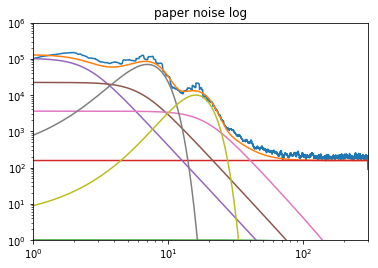

In [26]:
initial = np.array([156, 103617, 22301, 3590., 2.5,6.2, 18.8, 7.,2,70000,16,4,10000])
nwh, a1, a2, a3, b1, b2, b3, nu_max1,sig_nu1,amp1, nu_max2,sig_nu2,amp2 = initial
init_model = model(initial)
plt.plot(nu,pg_smooth,label='Power')
plt.plot(nu,init_model,label='Their best fit parameter models Model')
att = atten()
plt.plot(nu,att)
plt.plot(nu,nwh*np.ones_like(nu))
plt.plot(nu, att * (a1/(1+(nu/b1)**4)))
plt.plot(nu, att * (a2/(1+(nu/b2)**4)))
plt.plot(nu, att * (a3/(1+(nu/b3)**4)))


plt.plot(nu,att*amp1*np.exp(-(nu-nu_max1)**2/(2*sig_nu1**2)))
plt.plot(nu,att*amp2*np.exp(-(nu-nu_max2)**2/(2*sig_nu2**2)))


plt.xscale('log')
plt.yscale('log')
plt.xlim(1,300)
plt.ylim(1,10**6)
plt.title('paper noise log')

# plt.savefig('paper_noise_log.pdf')

# plt.figure()
# init_model = model(initial)
# plt.plot(nu,power,label='Power')
# plt.plot(nu,init_model,label='Their best fit parameter models Model')
# plt.plot(nu,atten())
# plt.plot(nu,156*np.ones_like(nu))
# plt.xlim(1,300)
# plt.title('paper noise')

# plt.savefig('paper_noise.pdf')

# plt.figure()
# plt.plot(nu,power/init_model,label='Power')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(1,300)
# plt.title('paper normalised log')

# plt.savefig('paper_normalised_log.pdf')

# plt.figure()
# plt.plot(nu,power/init_model,label='Power')

# plt.xlim(4,20)
# plt.title('paper normalised')

# plt.savefig('paper_normalised.pdf')

0 0
0 1
1 0
1 1
2 0
2 1
2 2
3 0
3 1
3 2
3 3
4 0
4 1
4 2
4 3
5 0
5 1
5 2


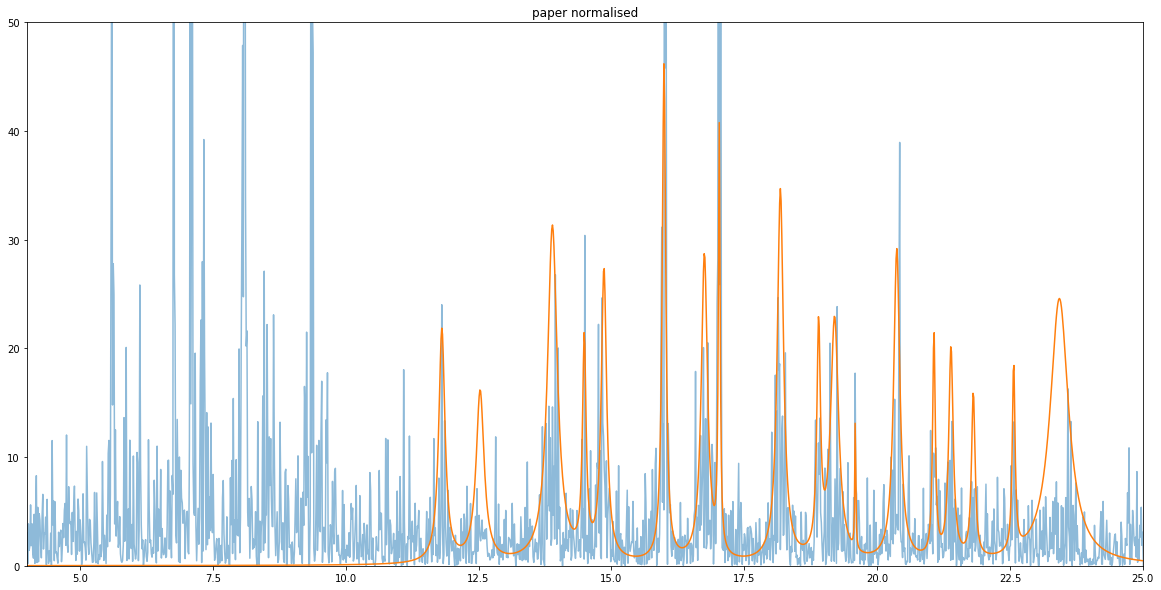

In [52]:



freqs = np.array([[11.81,12.53],[13.89,14.49],[14.86,15.99,16.75],[17.03,18.18,18.90,19.59],[19.20,20.37,21.07,21.81],[21.39,22.57,23.43]])
amplitudes = np.array([[0.86,0.63],[1.24,0.79],[1.07,1.83,1.13],[1.55,1.37,0.83,0.52],[0.89,1.15,0.83,0.61],[0.78,0.70,0.98]])
widths = np.array([[0.07,0.09],[0.11,0.04],[0.06,0.04,0.07],[0.02,0.07,0.04,0.01],[0.09,0.07,0.03,0.04],[0.05,0.03,0.21]])



def peaks():
    lor = np.zeros_like(nu)
    for i in range(len(freqs)):
        for j in range(len(freqs[i])):
            print(i,j)
            lor = lor + lorentzian_model(amplitudes[i][j],freqs[i][j],widths[i][j])
    return lor        
            
            

def lorentzian_model(amplitude, center, widt, nu = nu):
    lorentz = amplitude/(1+((nu-center)/widt)**2)
    return lorentz


#Write something that takes in all numax and delta nu and returns what the frequencies should be
# then fits the lorenzian to them

#so, we are only going to fit to those that are in the list given

peaks = peaks()



plt.figure()
plt.plot(nu,power/init_model,label='Power',alpha = 0.5)
plt.plot(nu, 25*peaks)

plt.xlim(4,25)
plt.ylim(0,50)
plt.title('paper normalised')

plt.savefig('looks_wrong.pdf')



    

In [110]:
#asymptotic relation
deltanu = 135.1

63/135.1 + 1 = epsilon

NameError: name 'epsilon' is not defined

In [27]:
#not sure about this error probably doesnt work well for a wide range of values as we have here
Perr = 1e-6
data = (nu, pg_smooth,Perr)
nwalkers = 500
niter = 1000
initial = np.array([156, 103617, 22301, 3590., 2,6.2, 18.8, 7.8,1.5,50000,17,4,10000])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...


  0%|          | 0/100 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


Running production...


100%|██████████| 1000/1000 [12:05<00:00,  1.38it/s]


In [29]:
def plotter(sampler,nu=nu,power=power, pg_smooth = pg_smooth):
    plt.ion()
    plt.plot(nu,power,label='Power')
    plt.plot(nu,pg_smooth)
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(nu, model(theta, nu), color="r", alpha=0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel(r'$\nu$')
    plt.ylabel('Power')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()
    plt.savefig('me.pdf')

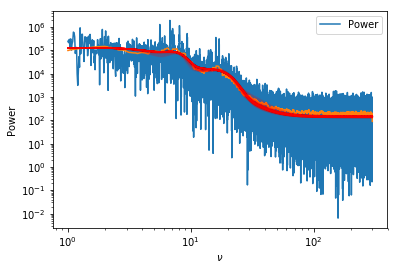

<Figure size 432x288 with 0 Axes>

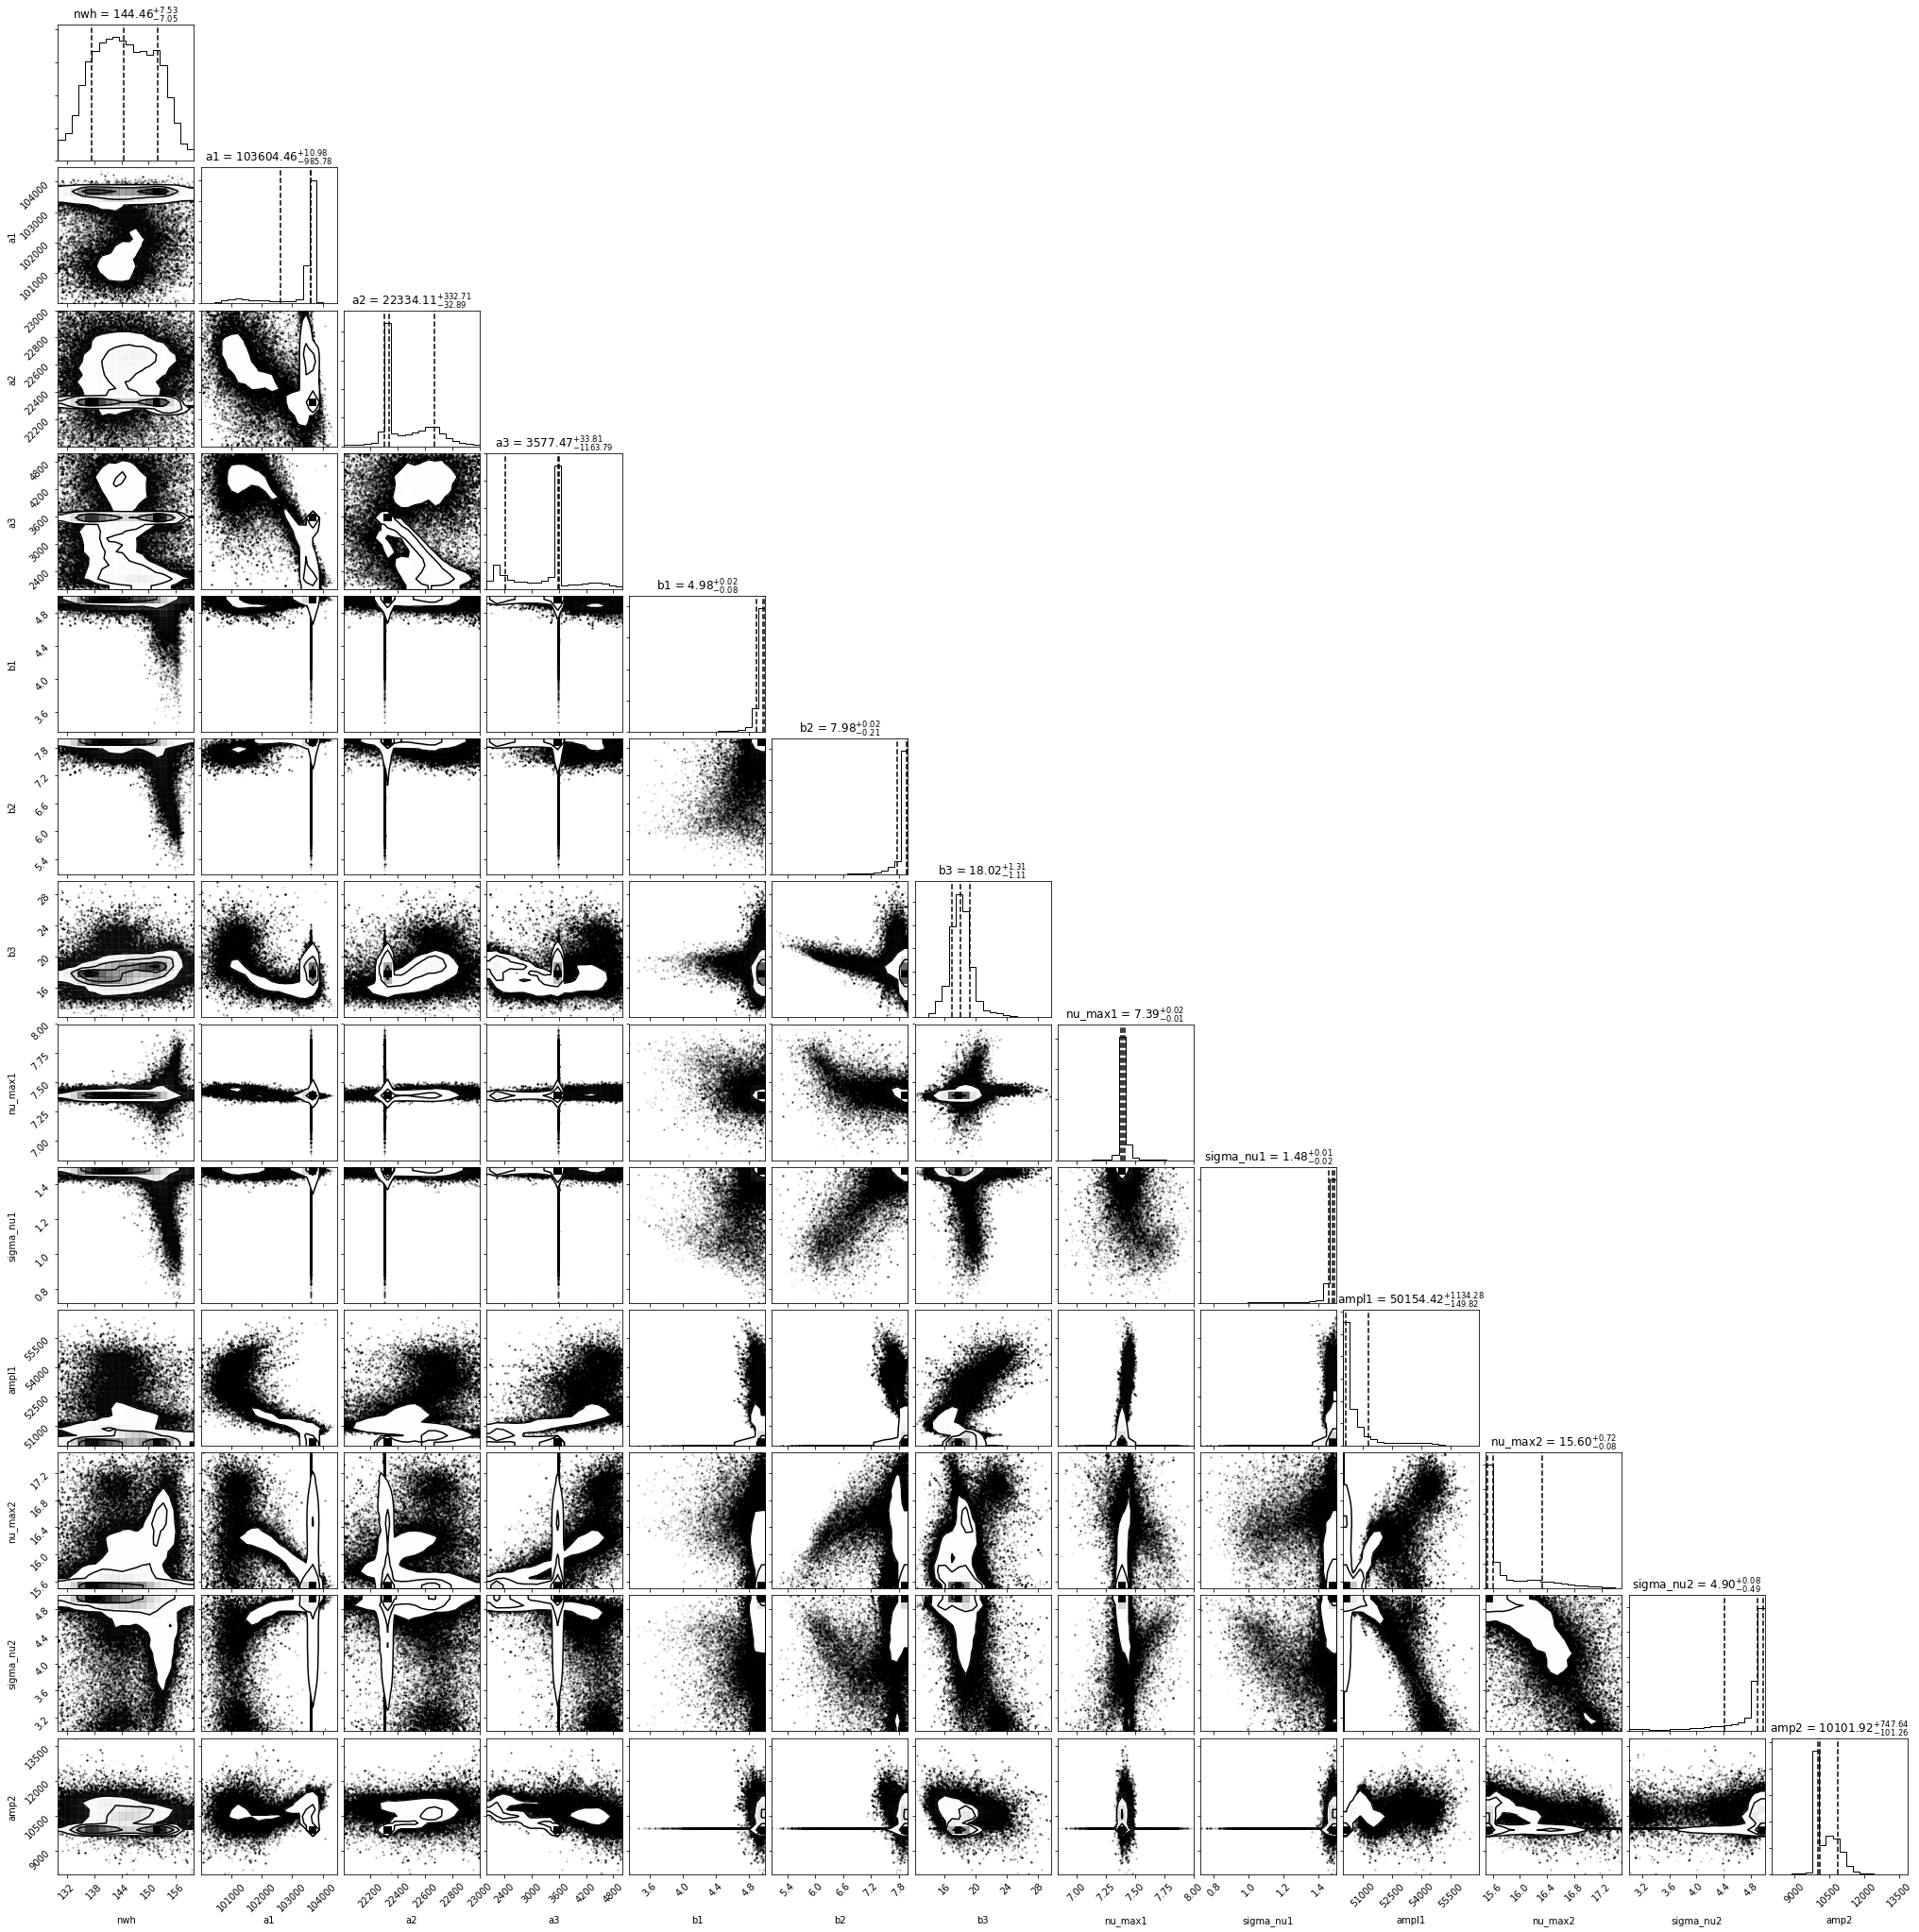

In [30]:
plotter(sampler)

labels = ['nwh','a1','a2','a3','b1','b2','b3','nu_max1','sigma_nu1','ampl1','nu_max2','sigma_nu2','amp2']
samples = sampler.flatchain
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

Theta max:  [1.45211579e+02 1.00777338e+05 2.24847796e+04 4.54754576e+03
 4.97081785e+00 7.99027495e+00 2.69228029e+01 7.48070601e+00
 1.47431161e+00 5.44569666e+04 1.69737483e+01 3.38086190e+00
 8.01889360e+03]


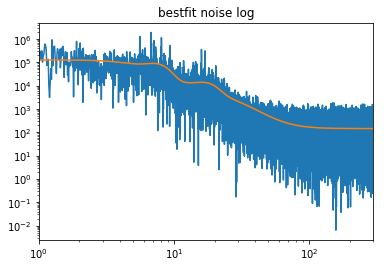

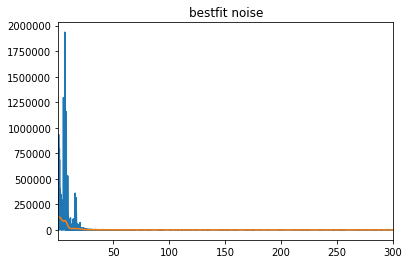

In [31]:
samples = sampler.flatchain

theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model(theta_max)
plt.plot(nu,power,label='Power')
plt.plot(nu,best_fit_model,label='Highest Likelihood Model')

plt.xscale('log')
plt.yscale('log')
plt.title('bestfit noise log')
plt.xlim(1,300)
plt.savefig('bestfit_noise_log.pdf')


plt.figure()
plt.plot(nu,power,label='Power')
plt.plot(nu,best_fit_model,label='Highest Likelihood Model')

plt.title('bestfit noise')
plt.xlim(1,300)
plt.savefig('bestfit_noise.pdf')
print ('Theta max: ',theta_max)

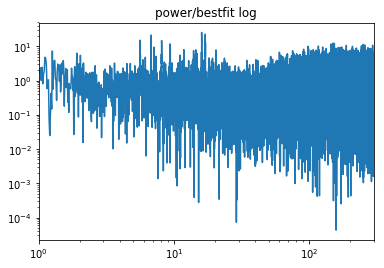

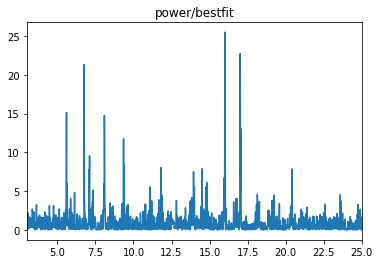

In [32]:
plt.plot(nu,power/best_fit_model,label='Highest Likelihood Model')
plt.title('power/bestfit log')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1,300)
plt.savefig('normalised_bestfit_log.pdf')

plt.figure()
plt.plot(nu,power/best_fit_model,label='Highest Likelihood Model')
plt.title('power/bestfit')
plt.xlim(3,25)
plt.savefig('normalised_bestfit.pdf')